# Phase 2 Project
**Client:** Zillow Group, Inc

## Overview
Zillow is an online real estate website that help home owners to buy, sell and rent homes. In order to give buyers and sellers a better idea of how much their homes should cost on the market, we will be using the dataset from King Country House Sales. The dataset has multiple potential attributes of a house that would justify a higher house price while others not as influencatial <br>
**Result 1:**   <br>
**Result 2:**   <br>

## Business Understanding 
Our main variable we are looking at is price and how each independent attributes influnce the price. The other data points such as latitude and longitude will not be considered for this project. A model would be needed to let seller know how much their house can sell for and whether a house is overpriced for the given features. 

## Data Understanding
Their are 30155 houses in the dataset with the following columns. The columns are to be seperate initially to prepare them to be added in the final model. SOme columns were changed to become eaiser to read or treated as categories for interpretation.

The following columns and attributed that will be include are: <br>
**Continuous Datatype:** 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_garage', 'sqft_patio' <br>
**Categorical Datatype:** 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'greenbelt', 'nuisance', 'condition', 'view', 'grade', 'heat_source', 'sewer_system' <br>
**Unused Attributes:** 'date', 'id', 'lat', 'long', 'address'<br>

*After exploring the dataset, I decided to remove these attributes for the following reason.* <br>
**sqft_above** - Similar or identical to sqft_living <br>
**nuisance** - Evenly split with relatively little different if a house have a nuisance or doesnt have a nuisance <br>

Due to the fact that buying and selling houses have a lot of attributes, we need to pick the best correlating attributes to make an effective model. We compared means of 'Yes', 'No' columns to see whether there was a big enough difference between the two as well as grouping houses that are the exception so that the models and graphs aren't skewed 

## Data Imports
Imported libraries that were used in the project.

In [1]:
import pandas as pd  
import resources as helpers    # Has data_exploration, data_preperation and data_visualization
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import scipy.stats as stats
import warnings
from itertools import combinations as cm    # 
warnings.filterwarnings("ignore")    # Used to temporary silence warnings
#%matplotlib inline

In [2]:
df = pd.read_csv('dsc-phase-2-project-v2-5-main/data/kc_house_data.csv')    #Read the file
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long
0,7399300360,5/24/2022,675000.0,4,1.0,1180,7140,1.0,NO,NO,...,PUBLIC,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052
1,8910500230,12/13/2021,920000.0,5,2.5,2770,6703,1.0,NO,NO,...,PUBLIC,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.35591
2,1180000275,9/29/2021,311000.0,6,2.0,2880,6156,1.0,NO,NO,...,PUBLIC,1580,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 9...",47.502045,-122.22520
3,1604601802,12/14/2021,775000.0,3,3.0,2160,1400,2.0,NO,NO,...,PUBLIC,1090,1070,200,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington...",47.566110,-122.29020
4,8562780790,8/24/2021,592500.0,2,2.0,1120,758,2.0,NO,NO,...,PUBLIC,1120,550,550,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washingt...",47.532470,-122.07188


### Initial Thoughts
There were very little missing values and only one duplicate in the dataset. Most column names were self-explainitory and had the correct format. 

In [3]:
## Setup for columns and subsets
useful_col = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront'
              , 'greenbelt', 'view', 'condition', 'grade', 'heat_source', 'sewer_system'
              , 'sqft_basement', 'sqft_garage', 'sqft_patio', 'nuisance', 'sqft_above','yr_built' , 'yr_renovated']

useless_col = ['date', 'id', 'lat', 'long', 'address']
categorical = [ 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'greenbelt',
               'view', 'condition', 'grade', 'heat_source', 'sewer_system']
object_categories = ['waterfront', 'greenbelt', 'view', 'condition', 'heat_source', 'sewer_system']
continuous = [column for column in useful_col if column not in categorical] # 'price','sqft_living', 'sqft_lot', 
                                                                            # 'sqft_basement', 'sqft_garage', 'sqft_patio'

## First Model

### Data Preperation 1
Before I can create a model with all of the given parameter, I need to prepare the categorical data and remove outliers. 

#### Data Cleaning - Overall Cleaning
1. Remove missing values
2. Remove duplicates
3. Remove unused columns
4. Rename grade

In [4]:
df_cleaned = helpers.dp.check_and_drop(df)    ## Dropped and removed rows that has small amount of missing values
df_cleaned = helpers.dp.outliers_remove(df_cleaned, 'price')    ## Remove outliers of price
df_cleaned.drop(labels = useless_col, axis = 1, inplace = True)    # Drop columns that wont be useful right now
df_cleaned['yr_built'] = df_cleaned['yr_built'] - df_cleaned['yr_built'].min()
## Map dictionary to change the strings in integer. 
grade_map = {'7 Average': 7, '8 Good': 8, '9 Better': 9, '6 Low Average': 6, '10 Very Good': 10, '5 Fair': 5, 
             '11 Excellent': 11, '4 Low': 4, '12 Luxury':12, '3 Poor': 3, '13 Mansion': 13, '2 Substandard' : 2}
df_cleaned.replace(grade_map, inplace= True)

## All categories and the number of times they appear
replaced_list = []
for column in list(object_categories):
    replace = df_cleaned[column].value_counts()[df_cleaned[column].value_counts()< 300]
    if len(replace) > 1:
        replaced_list.append(replace.index)
        df_cleaned[column].replace(replace.index, value= 'other',inplace= True)

Number of Missing Values: 46
Dropping rows: heat_source
Dropping rows: sewer_system
Number of Missing Values: 0
Number of duplicates: 1
Removed 1 duplicates
Number of duplicates: 0
1214 observations were removed. 


In [5]:
### General setup that prepares for the modeling
df_w_dummies = pd.get_dummies(df_cleaned, drop_first= True)
best_corr = helpers.dp.correlation_with(df_w_dummies, 'price')    ## Helper function that return the variables that correlate to a given column and return them as a list
best_corr[0]    ## The best correlating parameter

('sqft_living', 0.6019551412003955)

#### Model - Square Feet of Living 

In [6]:
X = df_w_dummies['sqft_living']    #One variable 
y = df_w_dummies['price']    # Always with price as dependent
model_living = sm.OLS(y, sm.add_constant(X))
result_living = model_living.fit()
print(result_living.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                 1.642e+04
Date:                Wed, 18 Jan 2023   Prob (F-statistic):               0.00
Time:                        15:26:48   Log-Likelihood:            -4.1338e+05
No. Observations:               28896   AIC:                         8.268e+05
Df Residuals:                   28894   BIC:                         8.268e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         2.61e+05   6094.353     42.822      

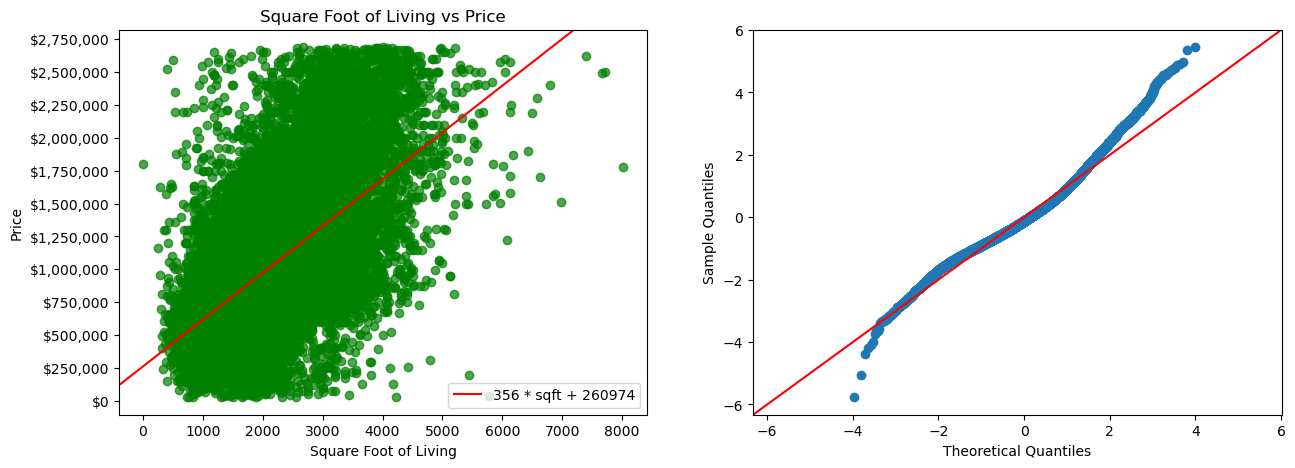

In [7]:
### Graph the scatter plot and the regression plot along the same plot
fig, ax = plt.subplots(ncols=2, figsize = (15,5))

ax[0].scatter(df_w_dummies['sqft_living'], df_w_dummies['price'], alpha = .7, color = 'green')
ax[0].set_ylabel('Price')
ax[0].set_xlabel('Square Foot of Living')

ax[0].set_title('Square Foot of Living vs Price')
y_ticks = np.arange(0,3000000, 250000)
y_ticks_str = ['${:,}'.format(y) for y in y_ticks]
ax[0].set_yticks(np.arange(0,3000000, 250000));
ax[0].set_yticklabels(y_ticks_str);

fig_1 = sm.graphics.abline_plot(model_results= result_living, ax = ax[0], color = 'red', label = '{} * sqft + {}'.format(round(result_living.params[1]), 
                                                                                                                      round(result_living.params[0])))
ax[0].legend();
fig_1_res = sm.graphics.qqplot(result_living.resid, dist=stats.norm, line='45', fit=True, ax= ax[1])

#### Model Exvaluation
**The given states that the starting cost of a house is $260,974 and for every square foot of living space a house has, the price increases by 355.** <br>

Our first model can explain **36.2%** of the variance of price with the parameter, sqft_living. sqft_living is statistically significant having a p-value less than .05. <br>
The single parameter perform well but we will try to see whether a combination of parameter can make the model better.

## Second Model
For the second model, we will be adding the second highest correlation with price. Grade had the second and is a numerical category data. 

In [8]:
best_corr[0:2]    ## The two best correlation

[('sqft_living', 0.6019551412003955), ('grade', 0.5765477030786343)]

#### Model - (result_living_grade)

In [9]:
X = df_w_dummies[[ 'sqft_living', 'grade']]
y = df_w_dummies['price']
model_living_grade = sm.OLS(y, sm.add_constant(X))
result_living_grade = model_living_grade.fit()
print(result_living_grade.summary())
print(result_living_grade.params)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                 1.038e+04
Date:                Wed, 18 Jan 2023   Prob (F-statistic):               0.00
Time:                        15:26:50   Log-Likelihood:            -4.1206e+05
No. Observations:               28896   AIC:                         8.241e+05
Df Residuals:                   28893   BIC:                         8.241e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -6.269e+05   1.79e+04    -35.113      

eval_env: 1
eval_env: 1


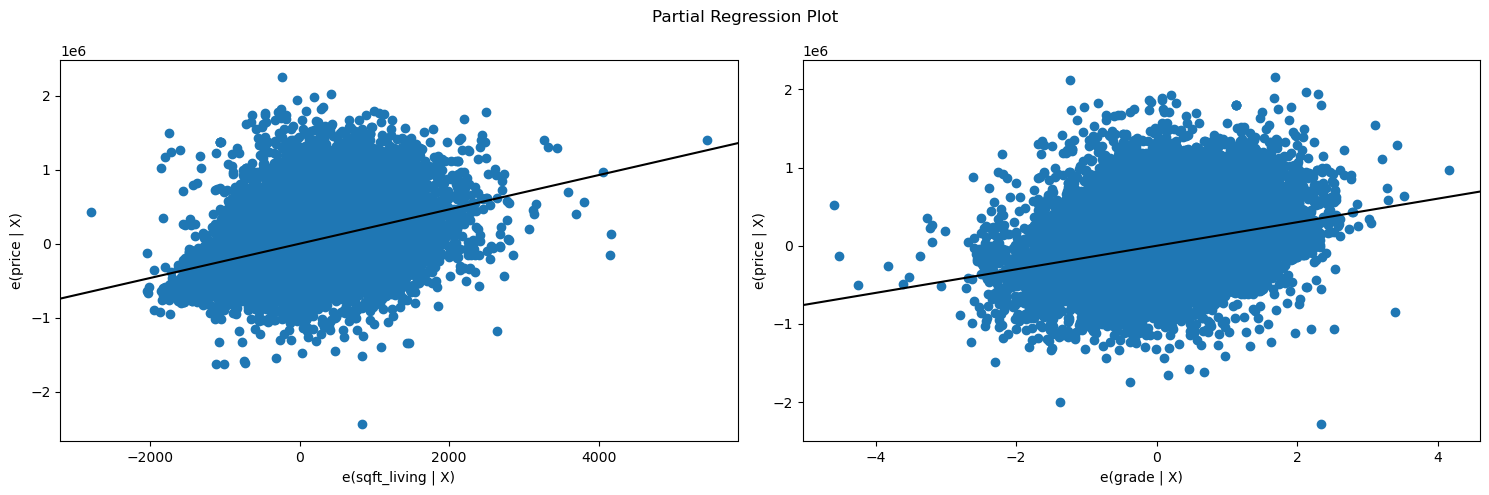

In [10]:
fig = plt.figure(figsize=(15,5));
sm.graphics.plot_partregress_grid(result_living_grade, exog_idx=["sqft_living", "grade"], fig= fig);
plt.tight_layout();

#### Model Evaluation
**The new model states that a price of a house starts with -626,890 and for every every square foot of living increase the price by 231. Alternatively, for every grade a house has, the price is expected to increase by 150,702.** <br>

Our new model now explain **41.8%** of the variance of the price with sqft_living and grade. Both sqft_living and grade are statistically significant with p-values less than .05. <br> 
This model make sense since a house with nothing, living space or grade has no value which is why the constant is negative. Square foot have an effect to the price but not as high as grade. Grade refer back to how the house well the house was built. Grade seems more impactful since they only range from 1-13 and both seems to positvitly effect the price of the house 


## Third Model

In [11]:
X = df_w_dummies[[ 'sqft_living', 'grade', 'sqft_garage']]
y = df_w_dummies['price']
model_liv_gra_bath = sm.OLS(y, sm.add_constant(X))
result_liv_gra_bath = model_liv_gra_bath.fit()
print(result_liv_gra_bath.summary())
print(result_liv_gra_bath.params)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     7172.
Date:                Wed, 18 Jan 2023   Prob (F-statistic):               0.00
Time:                        15:26:50   Log-Likelihood:            -4.1184e+05
No. Observations:               28896   AIC:                         8.237e+05
Df Residuals:                   28892   BIC:                         8.237e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -7.072e+05   1.81e+04    -39.012      

eval_env: 1
eval_env: 1
eval_env: 1


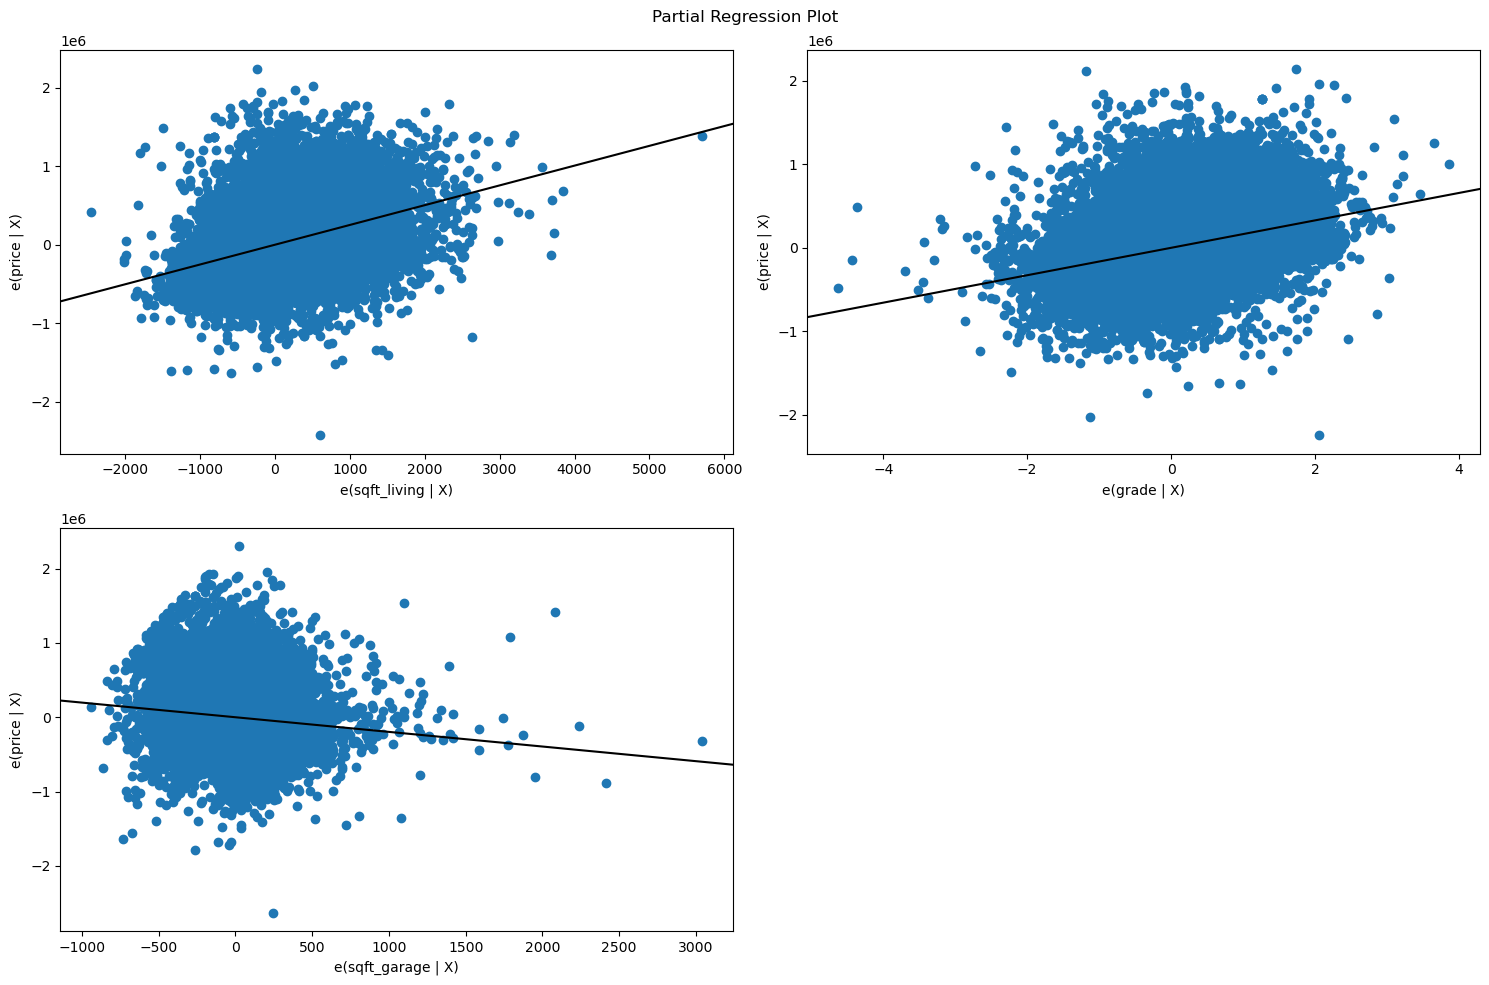

In [12]:
fig = plt.figure(figsize=(15,10));
sm.graphics.plot_partregress_grid(result_liv_gra_bath, exog_idx=["sqft_living", "grade", 'sqft_garage'], fig= fig);
plt.tight_layout();

#### Model Evaluation
Even though the bathrooms are statically significant, the parameter had no impact on the R squared and didn't appear to have a linear relationship with price when the partial regression was plotted. <br> Therefore, **bathrooms will be excluded in the final model.** <br>
This seems to be reasonable since the bathrooms doesn't seems to impact the quality of the house which seems to be the current strongest correlation to price. 


## Extra Models - No impact 
After some modeling with other parameter, bathrooms, bedrooms and sqft_patio appear to have little to no difference in the model so they were excluded from the model. 

In [13]:
results_list = {}
for param in ['bathrooms', 'bedrooms','sqft_patio', 'floors', 'view_GOOD']:
    x_list = ['sqft_living']
    x_list.append(param)
    
    X = df_w_dummies[x_list]
    y = df_w_dummies['price']
    model_temp = sm.OLS(y, sm.add_constant(X))
    result_temp = model_temp.fit()
    results_list[param] = result_temp
for results in results_list.keys():
    print('Parameter: Square Feet of Living = .362')
    print('Parameter: {} = {}'.format(results, round(results_list[results].rsquared, 3)))

Parameter: Square Feet of Living = .362
Parameter: bathrooms = 0.363
Parameter: Square Feet of Living = .362
Parameter: bedrooms = 0.368
Parameter: Square Feet of Living = .362
Parameter: sqft_patio = 0.366
Parameter: Square Feet of Living = .362
Parameter: floors = 0.363
Parameter: Square Feet of Living = .362
Parameter: view_GOOD = 0.365


## Extra Plots - Potentially significant
Although it is hard to interpret categorical variables, I was able to make some conclusion to have them included in the final model. <br> 
**Results**: The mean price of a house with or without nuisance are negilable while a house being at a waterfront or greenbelt has a significant difference. 

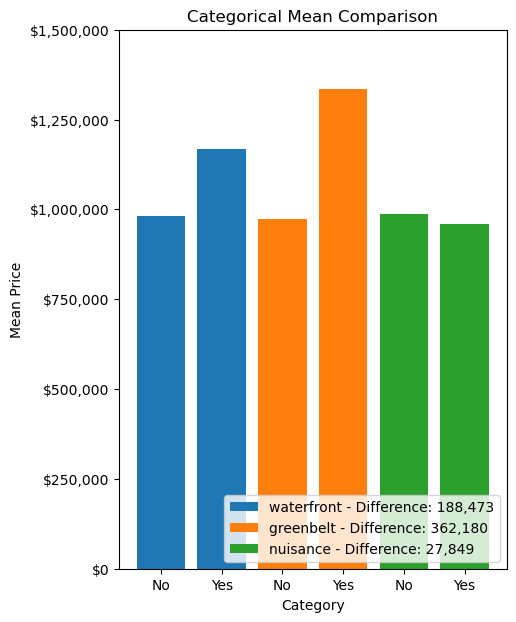

In [14]:
group_waterfront = df_cleaned[['waterfront', 'price']].groupby('waterfront').mean().values
x_group1 = [value[0] for value in group_waterfront.tolist()]
group_greenbelt = df_cleaned[['greenbelt', 'price']].groupby('greenbelt').mean().values
x_group2 = [value[0] for value in group_greenbelt.tolist()]
group_nuisance = df_cleaned[['nuisance', 'price']].groupby('nuisance').mean().values
x_group3 = [value[0] for value in group_nuisance.tolist()]

fig, ax = plt.subplots(figsize = (5, 7));    # Setup for plotting 
label = ['waterfront', 'greenbelt', 'nuisance']    #Labels for the legend and labels
r = np.arange(2)    # Spacing for the bar plots
width = 2    # Basic width of each bar
index = 0    # Index through all the groups

### Plot each of the groups side by side for clarity
for group in [x_group1, x_group2, x_group3]:
    ax.bar(r + width * index, group, label = '{} - Difference: {:,}'.format(label[index], abs(round(group[1]-group[0]))));
    index += 1
### Ticks labeling and spacing 
x_ticks = np.arange(6)    
y_ticks = np.arange(0,1750000, 250000)
y_ticks_str = ['${:,}'.format(y) for y in y_ticks]

plt.title('Categorical Mean Comparison');
plt.xlabel('Category')
plt.ylabel('Mean Price');
plt.xticks(x_ticks, ['No','Yes','No','Yes','No','Yes']);

ax.set_yticks(np.arange(0,1750000, 250000));
ax.set_yticklabels(y_ticks_str);

plt.legend(loc = 'lower right');

## Final Model
The final model will only have the following pararmeters: <br>
**'sqft_living', 'grade', 'sqft_garage'** <br>


In [15]:
X = df_w_dummies[[ 'sqft_living', 'grade', 'greenbelt_YES', 'waterfront_YES', 'sqft_garage', 'yr_built']]
y = df_w_dummies['price']
model_liv_gra_gar = sm.OLS(y, sm.add_constant(X))
result_liv_gra_gar = model_liv_gra_gar.fit()
print(result_liv_gra_gar.summary())
print(result_liv_gra_gar.params)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                     4244.
Date:                Wed, 18 Jan 2023   Prob (F-statistic):               0.00
Time:                        15:26:51   Log-Likelihood:            -4.1075e+05
No. Observations:               28896   AIC:                         8.215e+05
Df Residuals:                   28889   BIC:                         8.216e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -8.322e+05   1.77e+04    -47.

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


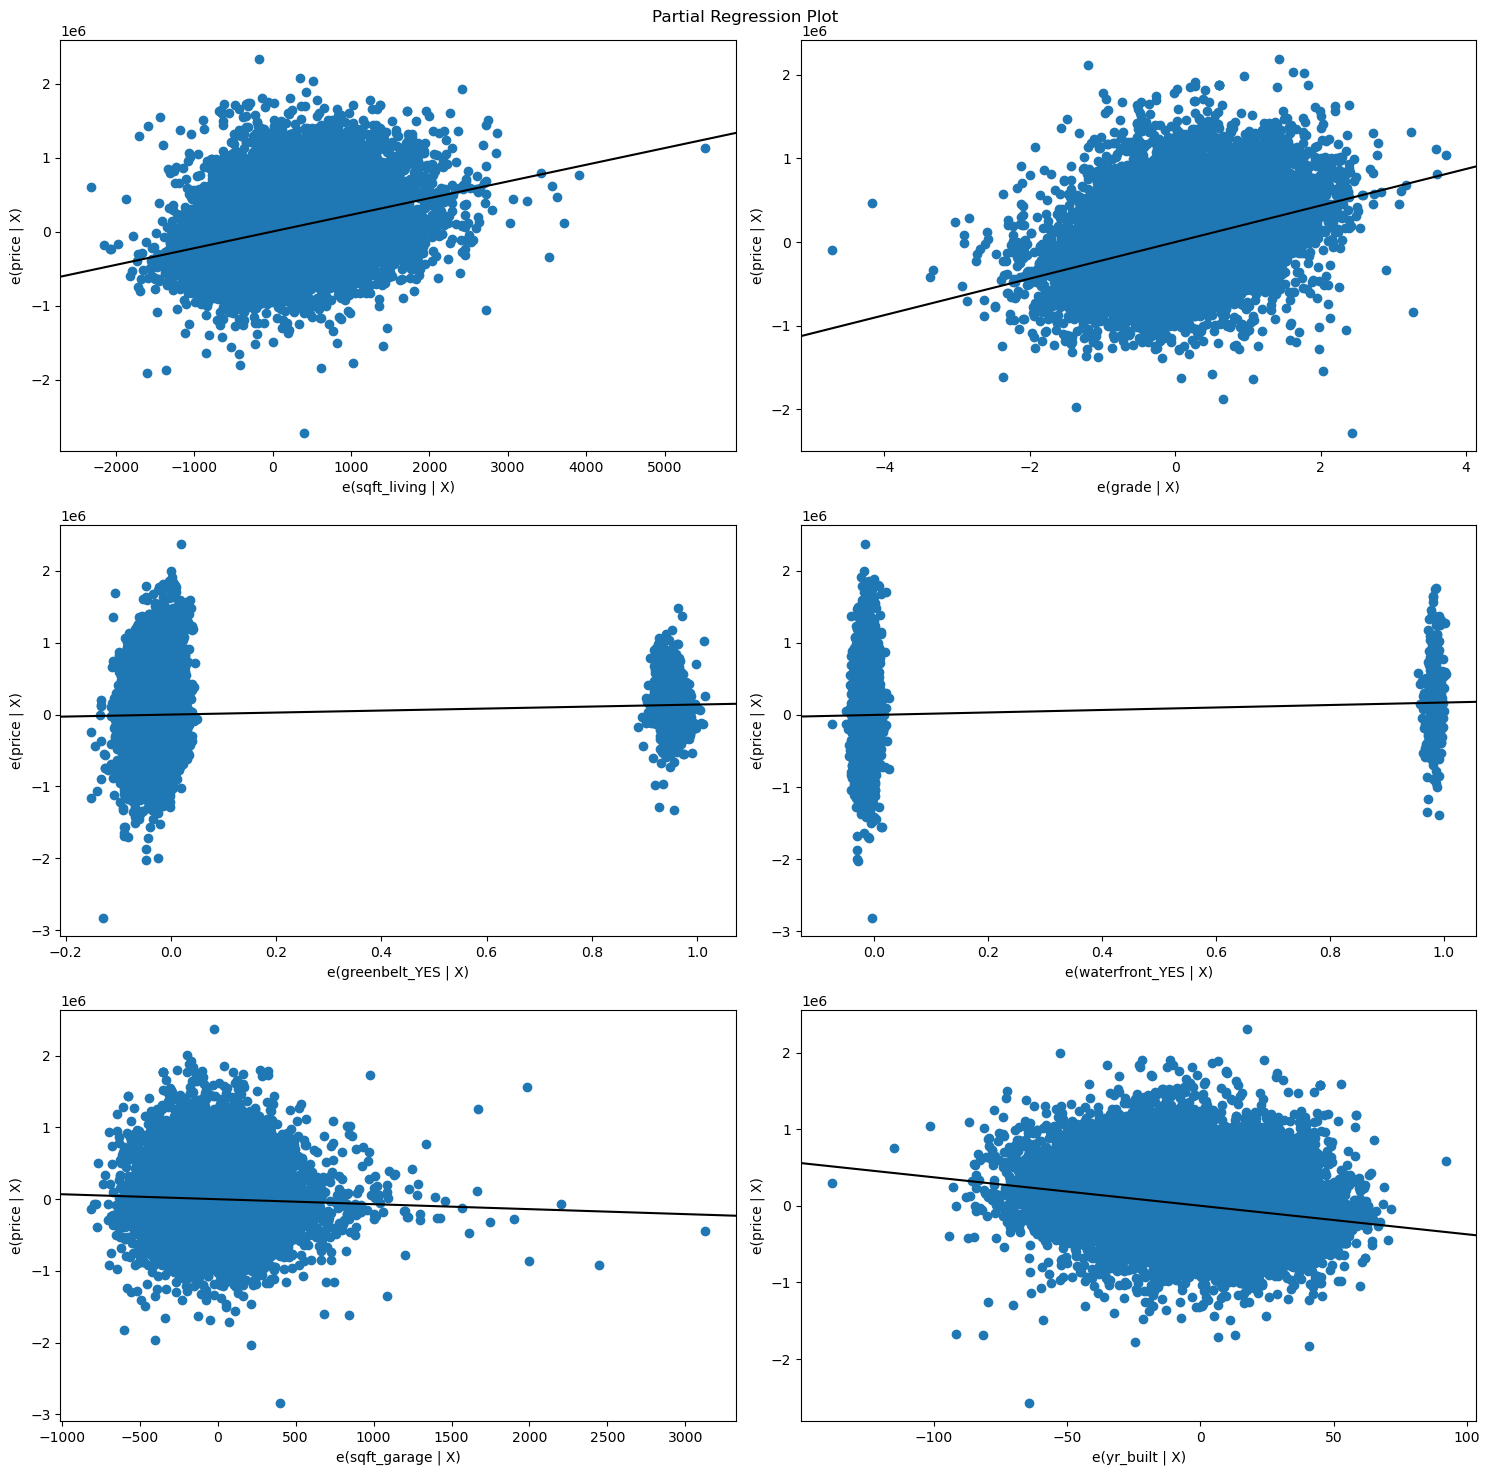

In [16]:
fig = plt.figure(figsize=(15,15));
sm.graphics.plot_partregress_grid(result_liv_gra_gar, exog_idx=[ 'sqft_living', 'grade', 'greenbelt_YES', 'waterfront_YES', 'sqft_garage','yr_built'], fig= fig);
plt.tight_layout();

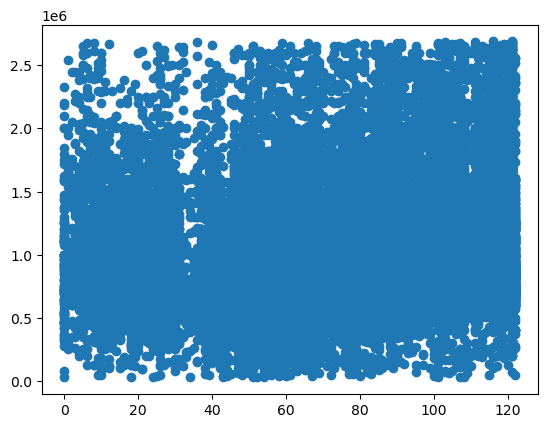

In [17]:
df_cleaned[['yr_built', 'price']]
plt.scatter(df_cleaned['yr_built'],df_cleaned['price'])

In [18]:
df_final = df_w_dummies[['price','sqft_living', 'grade', 'greenbelt_YES', 'waterfront_YES', 'sqft_garage','yr_built']].copy()

In [19]:
df_final['grade'] = df_final['grade'].astype(str)
df_final_dummies = pd.get_dummies(df_final, columns= ['grade'], drop_first= True)

In [20]:
df_final_dummies.columns

Index(['price', 'sqft_living', 'greenbelt_YES', 'waterfront_YES',
       'sqft_garage', 'yr_built', 'grade_11', 'grade_12', 'grade_13',
       'grade_2', 'grade_3', 'grade_4', 'grade_5', 'grade_6', 'grade_7',
       'grade_8', 'grade_9'],
      dtype='object')

In [21]:
X = df_final_dummies[df_final_dummies.columns[1:]]
y = df_final_dummies['price']
model_dummies = sm.OLS(y, sm.add_constant(X))
results_dummies = model_dummies.fit()
print(results_dummies.summary())
print(results_dummies.params)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                     1665.
Date:                Wed, 18 Jan 2023   Prob (F-statistic):               0.00
Time:                        15:26:53   Log-Likelihood:            -4.1044e+05
No. Observations:               28896   AIC:                         8.209e+05
Df Residuals:                   28879   BIC:                         8.211e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.436e+06   1.84e+04     78.

In [22]:
## All categories and the number of times they appear
replace = df_final['grade'].value_counts()[df_final['grade'].value_counts()< 300].index
df_final['grade'].replace(replace, value= 'other',inplace= True)

In [23]:
df_final['grade'].value_counts()

7        11643
8         9288
9         3545
6         2829
10         970
5          381
other      240
Name: grade, dtype: int64

In [24]:
df_final['grade'] = df_final['grade'].astype(str)
df_final_dummies = pd.get_dummies(df_final, columns= ['grade'], drop_first= True)
df_final_dummies

,price,sqft_living,greenbelt_YES,waterfront_YES,sqft_garage,yr_built,grade_5,grade_6,grade_7,grade_8,grade_9,grade_other
0,675000.0,1180,0,0,0,69,0,0,1,0,0,0
1,920000.0,2770,0,0,0,50,0,0,1,0,0,0
2,311000.0,2880,0,0,0,56,0,0,1,0,0,0
3,775000.0,2160,0,0,200,110,0,0,0,0,1,0
4,592500.0,1120,0,0,550,112,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
30150,1555000.0,1910,0,0,0,21,0,0,0,1,0,0
30151,1313000.0,2020,0,0,0,111,0,0,1,0,0,0
30152,800000.0,1620,0,0,240,95,0,0,1,0,0,0
30153,775000.0,2570,0,0,480,106,0,0,0,1,0,0


In [25]:
df_final_dummies['grade*price5'] = df_final_dummies['price'] * df_final_dummies['grade_5']
df_final_dummies['grade*price6'] = df_final_dummies['price'] * df_final_dummies['grade_6']
df_final_dummies['grade*price7'] = df_final_dummies['price'] * df_final_dummies['grade_7']
df_final_dummies['grade*price8'] = df_final_dummies['price'] * df_final_dummies['grade_8']
df_final_dummies['grade*price9'] = df_final_dummies['price'] * df_final_dummies['grade_9']
df_final_dummies['grade*price_o'] = df_final_dummies['price'] * df_final_dummies['grade_other']

In [26]:
X = df_final_dummies[df_final_dummies.columns[1:]]
y = df_final_dummies['price']
model_dummies = sm.OLS(y, sm.add_constant(X))
results_dummies = model_dummies.fit()
print(results_dummies.summary())
print(results_dummies.params)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                 4.271e+04
Date:                Wed, 18 Jan 2023   Prob (F-statistic):               0.00
Time:                        15:26:53   Log-Likelihood:            -3.7273e+05
No. Observations:               28896   AIC:                         7.455e+05
Df Residuals:                   28878   BIC:                         7.456e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.806e+06   5000.504    361.

In [27]:
df_interaction = df_w_dummies[['price','sqft_living', 'grade']].copy()

In [28]:
df_interaction['grade*price'] = df_interaction['grade'] * df_interaction['price']

In [29]:
df_test = df_interaction[['price', 'grade*price']]

In [30]:
X = df_test[df_test.columns[1:]]
y = df_test['price']
model_dummies = sm.OLS(y, sm.add_constant(X))
results_dummies = model_dummies.fit()
print(results_dummies.summary())
print(results_dummies.params)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                 5.487e+05
Date:                Wed, 18 Jan 2023   Prob (F-statistic):               0.00
Time:                        15:26:53   Log-Likelihood:            -3.7661e+05
No. Observations:               28896   AIC:                         7.532e+05
Df Residuals:                   28894   BIC:                         7.532e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.997e+05   1241.620    160.816      

In [31]:
df_interaction['sqft_living*price'] = df_interaction['sqft_living'] * df_interaction['price']
df_test = df_interaction[['price', 'sqft_living', 'sqft_living*price']]
X = df_test[df_test.columns[1:]]
y = df_test['price']
model_dummies = sm.OLS(y, sm.add_constant(X))
results_dummies = model_dummies.fit()
print(results_dummies.summary())
print(results_dummies.params)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                 1.016e+05
Date:                Wed, 18 Jan 2023   Prob (F-statistic):               0.00
Time:                        15:26:53   Log-Likelihood:            -3.8978e+05
No. Observations:               28896   AIC:                         7.796e+05
Df Residuals:                   28893   BIC:                         7.796e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              8.415e+05   3174.90

In [32]:
%matplotlib nbagg
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

# Set up 3D scatter plot
ax.scatter(
    df_w_dummies["price"],      # x axis
    df_w_dummies["sqft_living"],         # y axis
    df_w_dummies["grade"],  # z axis
    c=df_w_dummies["grade"],
    cmap="viridis"
)
ax.set_xlabel("price")
ax.set_ylabel("sqft_living")
ax.set_zlabel("grade");

<IPython.core.display.Javascript object>